https://www.youtube.com/watch?v=luiJttJVeBA&ab_channel=datadrenaline

https://www.youtube.com/watch?v=czd9a2Rc-h4&ab_channel=DataCamp

https://dockerlabs.collabnix.com/docker/cheatsheet/

https://mlconference.ai/blog/real-time-anomaly-detection-with-kafka-and-isolation-forests/?gclid=Cj0KCQjwqc6aBhC4ARIsAN06NmMN_ObP_nI-oxDgHQZq9jKOVwJFRe2lTLMkhpQgWJaPVVWH9RuOQjYaAplvEALw_wcB

https://medium.com/@sidjain1412/anomaly-detection-for-time-series-data-dc92a1d1a49f

https://medium.com/@alex.huang1117/how-to-detect-anomalies-without-labels-project-overview-9b91332201d5

In [2]:

from pyspark.sql import SparkSession
import pandas as pd
import numpy as np
import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import pandas as pd 




In [3]:
from pyspark.sql.functions import *
spark = SparkSession.builder.master('local[*]').appName('spark_app').getOrCreate()
df = spark.read.csv('DBA80.csv', header=True,inferSchema=True, sep=';').orderBy('TimeStamp',ascending = True)

df = df.withColumn('ActualPos', regexp_replace('ActualPos', ',', '.'))
df = df.withColumn('ActualPos', df['ActualPos'].cast('double'))
df.printSchema()

pdf = df.toPandas()


root
 |-- TimeStamp: timestamp (nullable = true)
 |-- ActualPos: double (nullable = true)
 |-- ActualForce: integer (nullable = true)
 |-- Nahtnummer: string (nullable = true)
 |-- LaserPwr: integer (nullable = true)
 |-- Befehl: string (nullable = true)



In [4]:
pdf.head(10)


,TimeStamp,ActualPos,ActualForce,Nahtnummer,LaserPwr,Befehl
0,2020-09-22 10:52:31.972,-1.3,-695,KIM,377,PUTG348_46360637
1,2020-09-22 10:52:32.522,-1.0,-684,KIO,0,PUTG348_46360632
2,2020-09-22 10:52:34.425,0.6,-691,KIJ,375,PUTG348_46360634
3,2020-09-22 10:52:35.141,1.1,-691,KIK,375,PUTG348_46360635
4,2020-09-22 10:52:35.879,1.4,-693,KIL,335,PUTG348_46360636
5,2020-09-22 10:52:38.566,1.9,-693,KHO,376,PUTG348_46360631
6,2020-09-22 10:52:39.299,1.6,-691,KIG,376,PUTG348_46360630
7,2020-09-22 10:52:40.037,1.5,-705,KHP,375,PNB335
8,2020-09-22 10:52:40.431,-11.4,307,KHP,0,PNB343
9,2020-09-22 10:52:44.129,0.3,-688,FIPC,382,PUTG348_46360642


In [5]:
pdf.describe()


,ActualPos,ActualForce,LaserPwr
count,1000000.000000,1000000.000000,1000000.000000
mean,-8.174710,-574.953371,268.952781
std,136.541504,4021.754611,177.650401
min,-8192.000000,-151386.000000,0.000000
25%,-0.500000,-693.000000,0.000000
50%,0.800000,-691.000000,376.000000
75%,1.400000,-520.000000,396.000000
max,8191.900000,151388.000000,408.000000


In [6]:
q2 = 0.99
q1 = 0.01
multi = 1.5
q2_F = pdf.ActualForce.quantile(q2)
q1_F = pdf.ActualForce.quantile(q1)

iqr_F = q2_F-q1_F

q2_P = pdf.ActualPos.quantile(q2)
q1_P = pdf.ActualPos.quantile(q1)

iqr_P = q2_P-q1_P


pdf_clean = pdf[(pdf.ActualForce < q2_F+(multi*iqr_F)) & (pdf.ActualForce > q1_F-(multi*iqr_F)) & (pdf.ActualPos < q2_P+(multi*iqr_P)) & (pdf.ActualPos > q1_P-(multi*iqr_P))]

pdf_clean.describe()


,ActualPos,ActualForce,LaserPwr
count,999029.000000,999029.000000,999029.000000
mean,-9.643305,-514.509987,269.190766
std,25.166300,373.544499,177.549117
min,-72.800000,-1922.000000,0.000000
25%,-0.500000,-693.000000,0.000000
50%,0.800000,-691.000000,376.000000
75%,1.400000,-520.000000,396.000000
max,22.300000,718.000000,408.000000


In [7]:
pdf_clean.groupby('Befehl').count().reset_index().sort_values('TimeStamp',ascending=False)

,Befehl,TimeStamp,ActualPos,ActualForce,Nahtnummer,LaserPwr
90,PUTG348_46360638,53644,53644,53644,53644,53644
77,PUTG348_46360610,45044,45044,45044,45044,45044
92,PUTG348_46360641,44776,44776,44776,44776,44776
78,PUTG348_46360622,44522,44522,44522,44522,44522
84,PUTG348_46360632,44202,44202,44202,44202,44202
...,...,...,...,...,...,...
39,PNB320,1,1,1,1,1
53,PNB42,1,1,1,1,1
118,PUTG463_46360775,1,1,1,1,1
120,PUTG463_46360778,1,1,1,1,1


<AxesSubplot: xlabel='TimeStamp', ylabel='Befehl'>

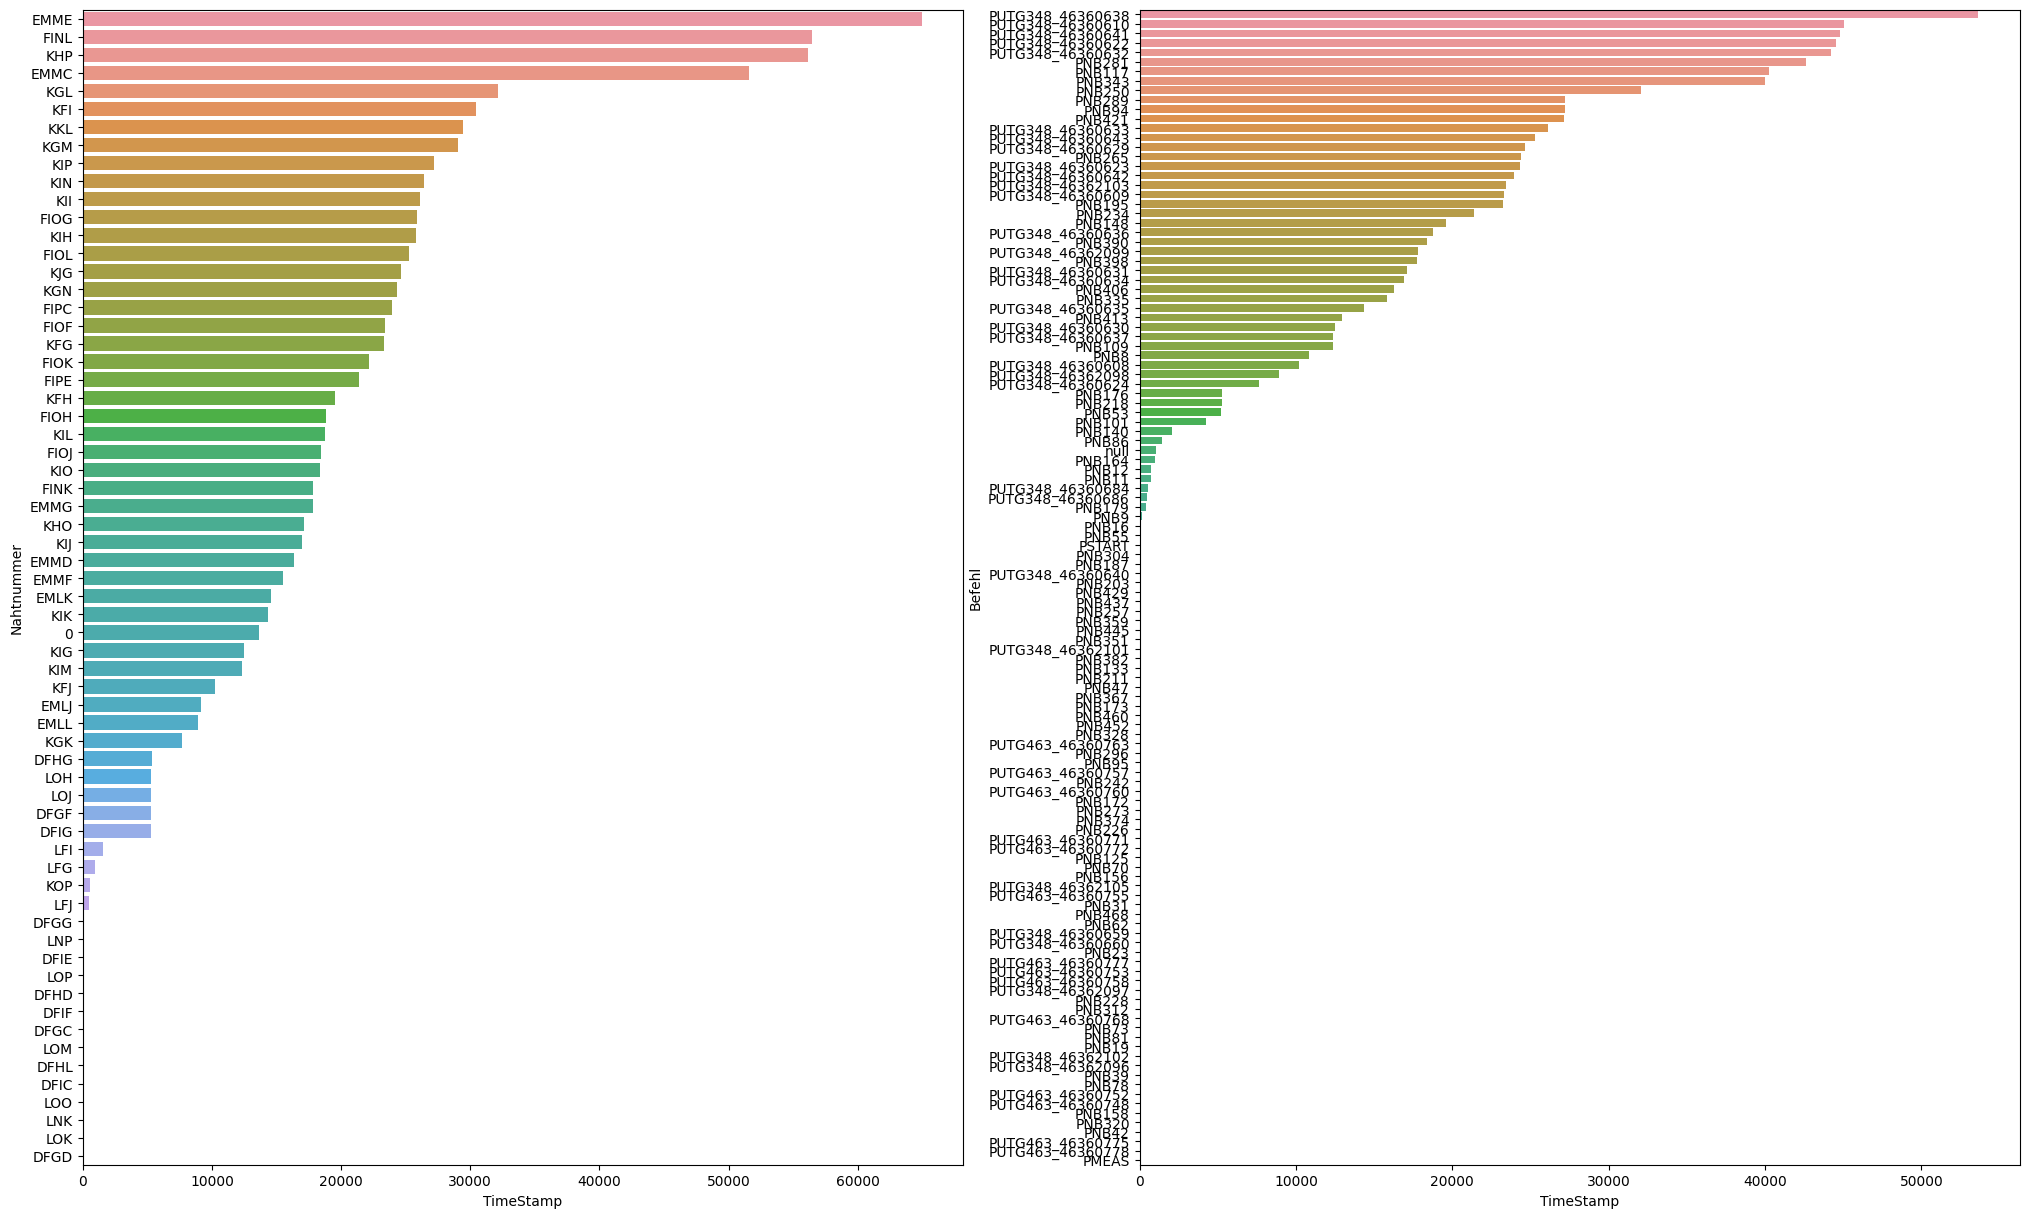

In [8]:
fig,ax = plt.subplots(1,2,figsize=(25,15))
sns.barplot(data=pdf_clean.groupby('Nahtnummer').count().reset_index().sort_values(
    'TimeStamp', ascending=False), y='Nahtnummer', x='TimeStamp', ax=ax[0])
sns.barplot(data=pdf_clean.groupby('Befehl').count().reset_index().sort_values('TimeStamp', ascending=False),
            y='Befehl', x='TimeStamp', ax=ax[1])


In [9]:
pvtble=pdf_clean.pivot_table(index='Befehl',columns='Nahtnummer',values='ActualPos',aggfunc='count')

<AxesSubplot: ylabel='Befehl'>

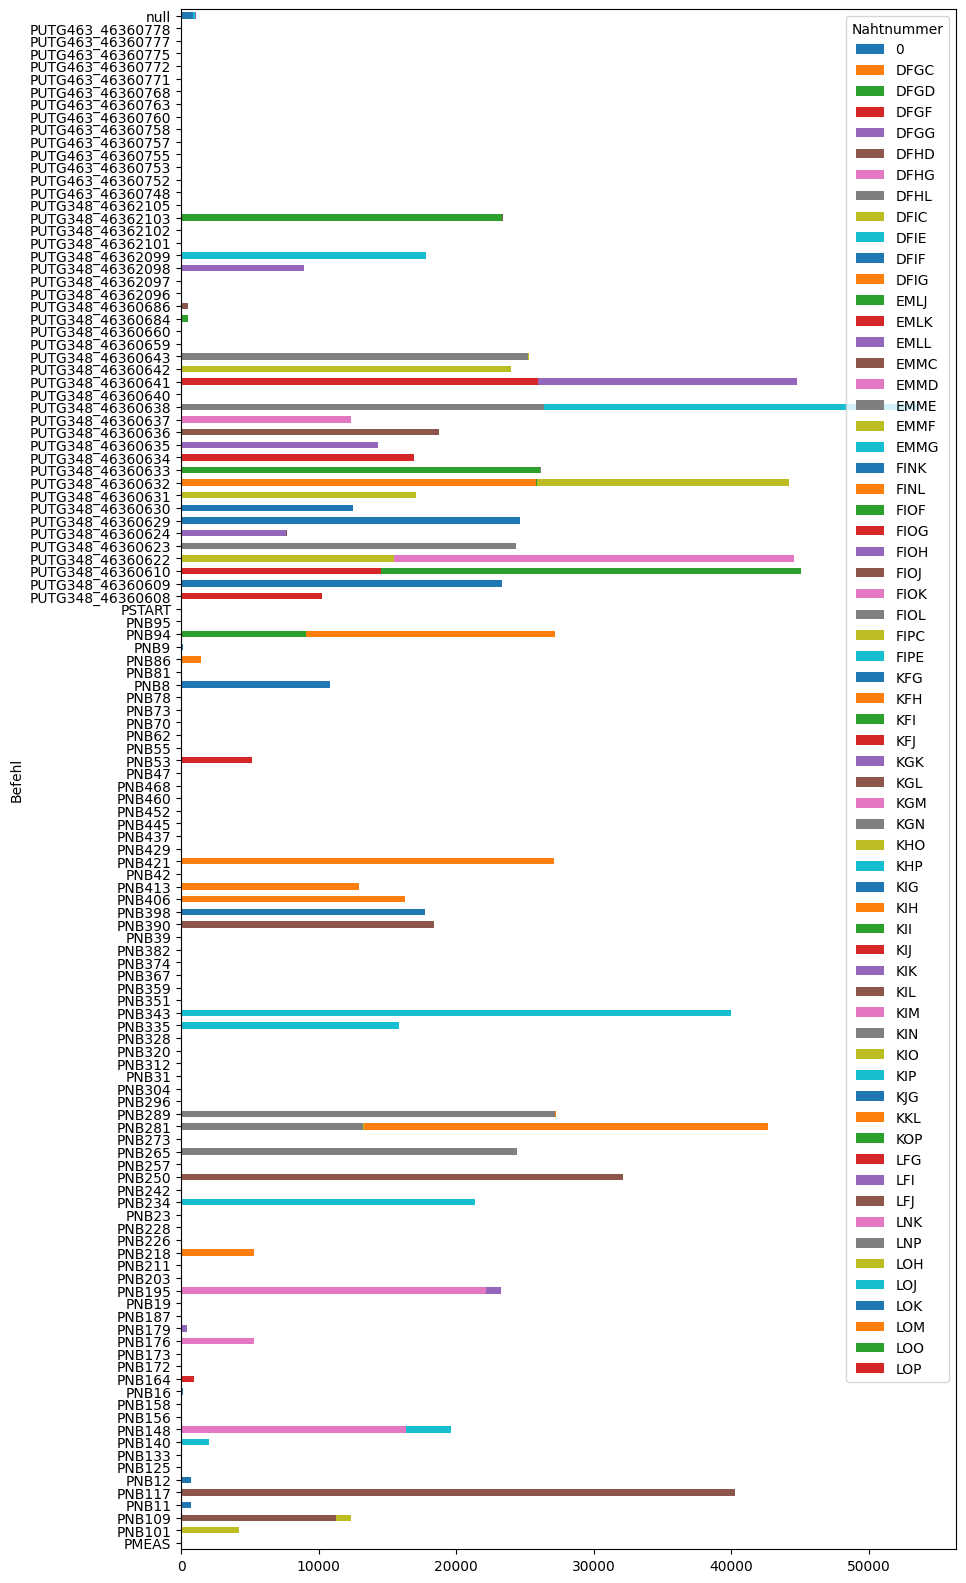

In [10]:
pvtble.plot(kind='barh',stacked=True, figsize=(10,20))

(-936.0, 266.0)
(0.6, 14.0)


<AxesSubplot: xlabel='ActualPos', ylabel='ActualForce'>

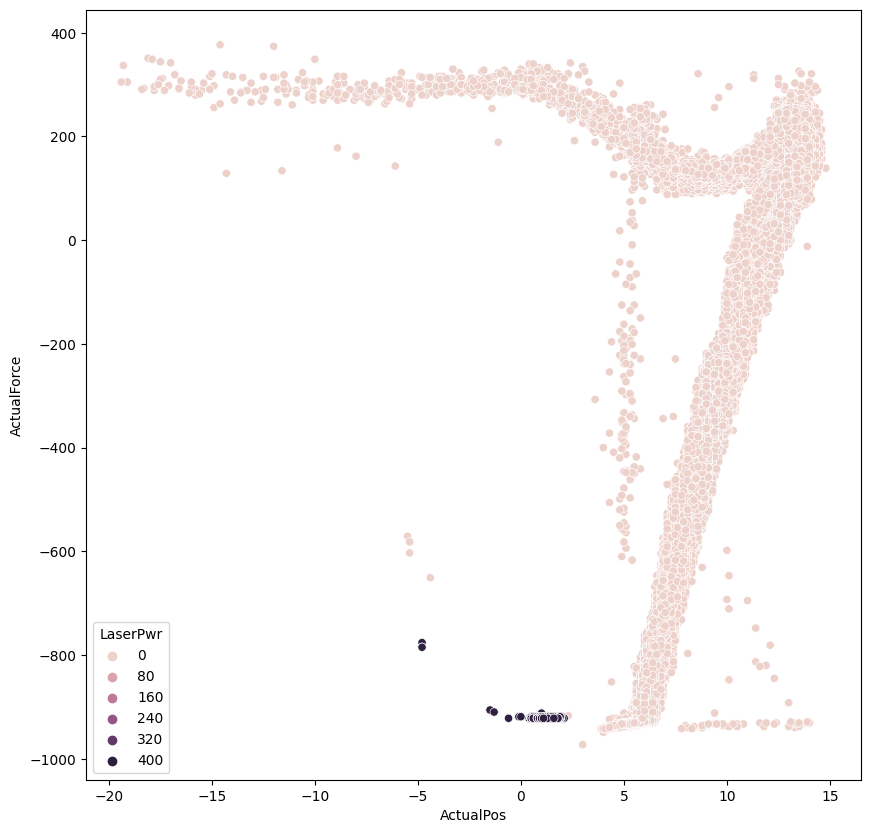

In [11]:

pdf_n=pdf[(pdf.Nahtnummer == 'EMME')]

q2=0.99
q1=0.01
multi=1.5
q2_F = pdf_n.ActualForce.quantile(q2)
q1_F = pdf_n.ActualForce.quantile(q1)

iqr_F=q2_F-q1_F

q2_P = pdf_n.ActualPos.quantile(q2)
q1_P = pdf_n.ActualPos.quantile(q1)

iqr_P = q2_P-q1_P

print((q1_F,q2_F))
print((q1_P, q2_P))

fig = plt.figure(figsize=(10, 10))
sns.scatterplot(data=pdf_n[(pdf_n.ActualForce < q2_F+(multi*iqr_F)) & (pdf_n.ActualForce > q1_F-(multi*iqr_F)) &
                           (pdf_n.ActualPos < q2_P+(multi*iqr_P)) & (pdf_n.ActualPos > q1_P-(multi*iqr_P))], x='ActualPos', y='ActualForce', hue='LaserPwr')


<AxesSubplot: xlabel='ActualPos', ylabel='Count'>

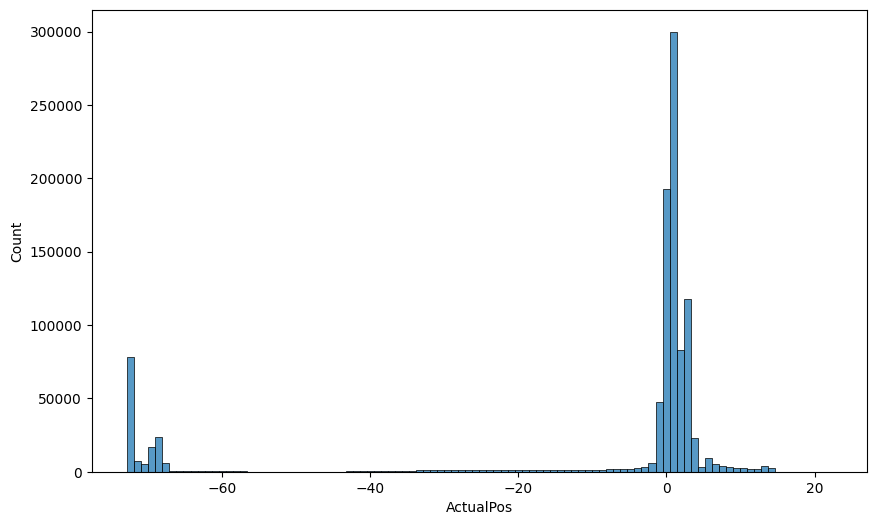

In [12]:
fig = plt.figure(figsize=(10, 6))
sns.histplot(data=pdf_clean,x='ActualPos', bins=100)

<AxesSubplot: xlabel='ActualForce', ylabel='Count'>

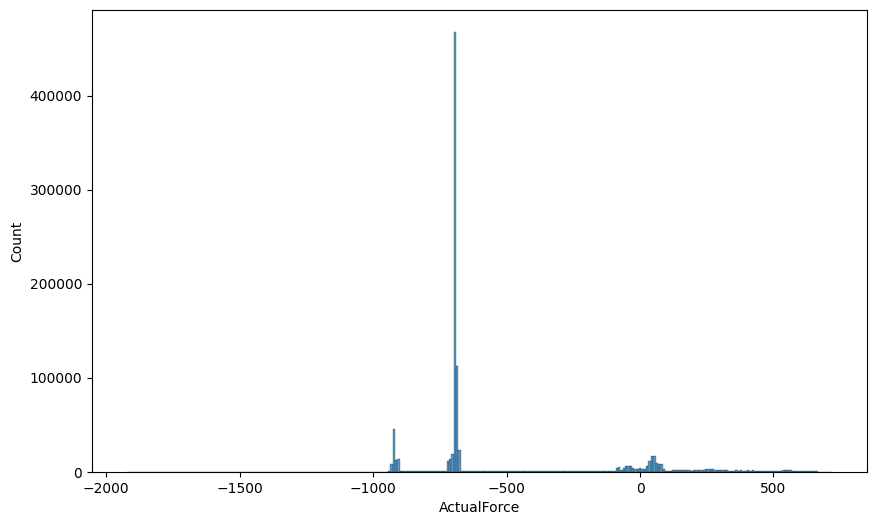

In [136]:
fig = plt.figure(figsize=(10,6))
sns.histplot(data=pdf_clean, x='ActualForce', bins=300)

<AxesSubplot: xlabel='LaserPwr', ylabel='Count'>

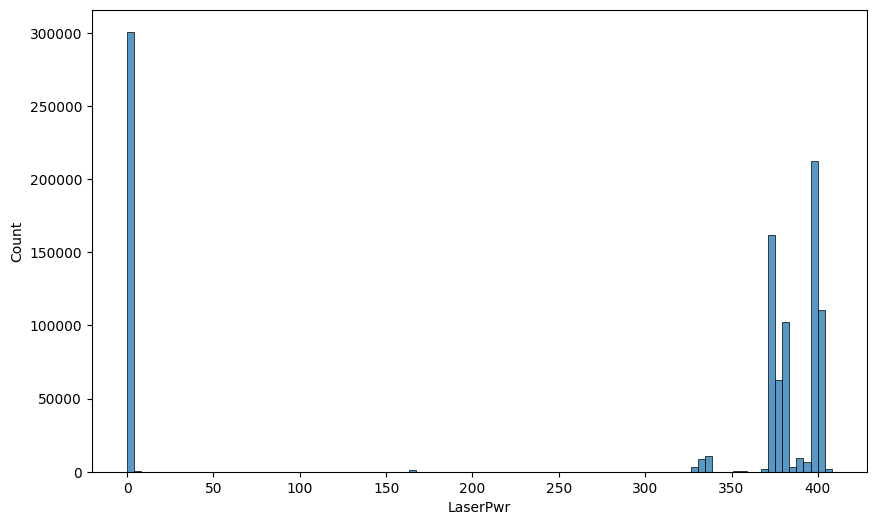

In [14]:
fig = plt.figure(figsize=(10, 6))
sns.histplot(data=pdf_clean, x='LaserPwr', bins=100)


In [15]:

fig = plt.figure(figsize=(10, 25))
sns.barplot(data=pdf.groupby('Date').count().reset_index(),x='TimeStamp',y='Date')


KeyError: 'Date'

<Figure size 1000x2500 with 0 Axes>

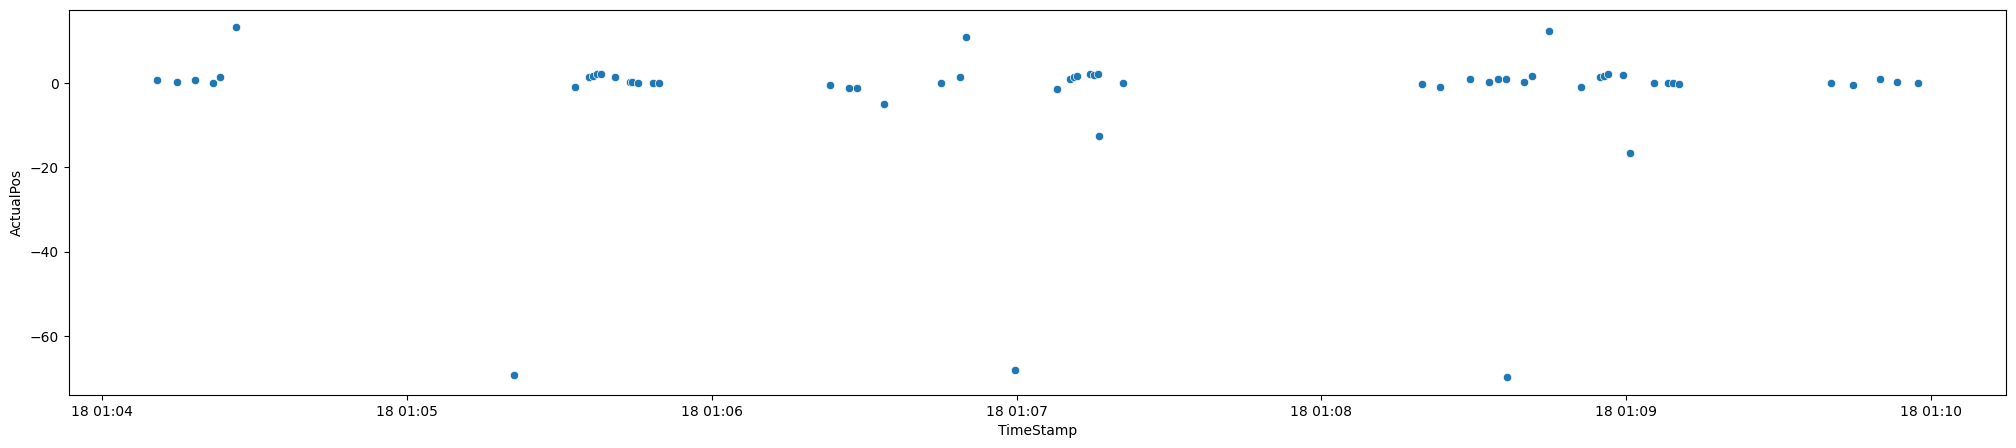

In [ ]:

fig = plt.figure(figsize=(25, 5))

g = sns.scatterplot(data=pdf[(pdf.TimeStamp > '2020-11-17 12:00:00') &
                 (pdf.TimeStamp < '2020-11-18 01:10:00')], x='TimeStamp', y='ActualPos')
#g.set(yscale='log')


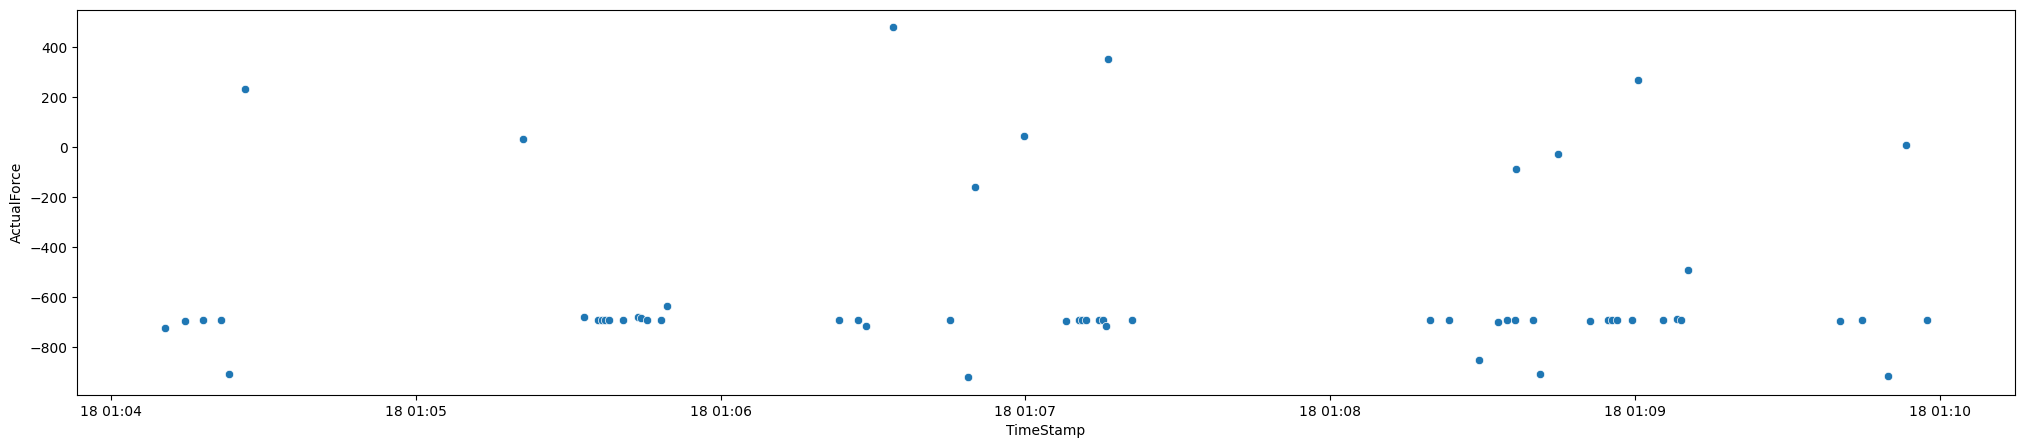

In [ ]:
fig = plt.figure(figsize=(25, 5))

g = sns.scatterplot(data=pdf[(pdf.TimeStamp > '2020-11-17 12:00:00') &
                 (pdf.TimeStamp < '2020-11-18 01:10:00')], x='TimeStamp', y='ActualForce')


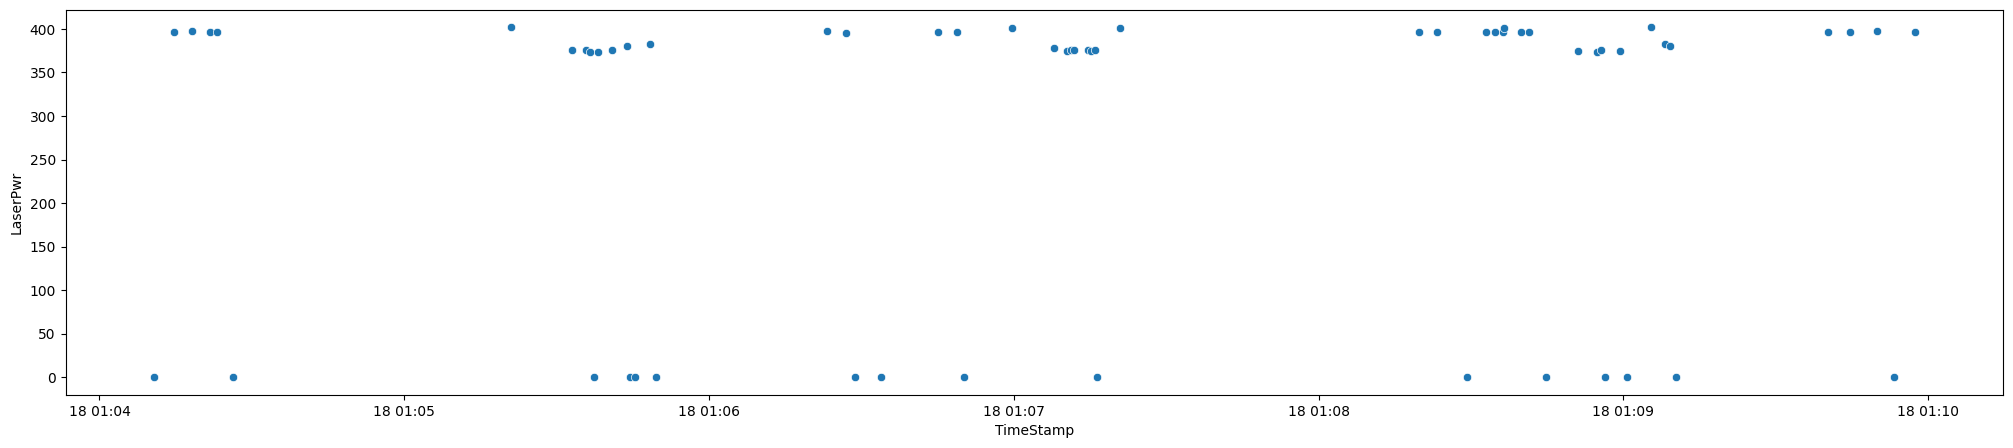

In [ ]:
fig = plt.figure(figsize=(25, 5))

g = sns.scatterplot(data=pdf[(pdf.TimeStamp > '2020-11-17 12:00:00') &
                 (pdf.TimeStamp < '2020-11-18 01:10:00')], x='TimeStamp', y='LaserPwr')


In [ ]:
pdf[(pdf.TimeStamp>"2020-11-18 01:00:00")&(pdf.TimeStamp<"2020-11-18 01:30:00")]

,TimeStamp,ActualPos,ActualForce,Nahtnummer,LaserPwr,Befehl,Date
45489,2020-11-18 01:04:10.675,0.8,-725,EMMC,0,PNB117,2020-11-18
45490,2020-11-18 01:04:14.596,0.4,-698,EMMF,397,PUTG348_46360622,2020-11-18
45491,2020-11-18 01:04:18.140,0.8,-693,KGN,398,PUTG348_46360623,2020-11-18
45492,2020-11-18 01:04:21.693,0.1,-691,KGL,397,PNB250,2020-11-18
45493,2020-11-18 01:04:23.143,1.6,-908,EMMG,396,PUTG348_46362099,2020-11-18
...,...,...,...,...,...,...,...
45570,2020-11-18 01:22:08.945,0.9,-691,KGM,397,PUTG348_46360622,2020-11-18
45571,2020-11-18 01:22:10.303,0.9,-691,KGN,396,PUTG348_46360623,2020-11-18
45572,2020-11-18 01:22:14.206,0.1,-691,KGL,397,PNB250,2020-11-18
45573,2020-11-18 01:22:17.947,1.3,-922,EMME,398,PNB265,2020-11-18


In [ ]:
pdf[pdf.ActualPos > 1].describe()

,ActualPos,ActualForce,LaserPwr
count,352036.000000,352036.000000,352036.000000
mean,8.100295,-781.437552,270.763496
std,206.507095,4231.035632,170.845625
min,1.100000,-151386.000000,0.000000
25%,1.400000,-693.000000,0.000000
50%,2.400000,-691.000000,375.000000
75%,3.000000,-688.000000,378.000000
max,8191.900000,621.000000,405.000000


### Data Preperation

In [ ]:
X=pdf_clean.to_numpy()

In [ ]:
pdf_clean.iloc[0:5,:]


,TimeStamp,ActualPos,ActualForce,Nahtnummer,LaserPwr,Befehl
0,2020-09-22 10:52:31.972,-1.3,-695,KIM,377,PUTG348_46360637
1,2020-09-22 10:52:32.522,-1.0,-684,KIO,0,PUTG348_46360632
2,2020-09-22 10:52:34.425,0.6,-691,KIJ,375,PUTG348_46360634
3,2020-09-22 10:52:35.141,1.1,-691,KIK,375,PUTG348_46360635
4,2020-09-22 10:52:35.879,1.4,-693,KIL,335,PUTG348_46360636


In [172]:
import numpy as np
from sklearn.preprocessing import OneHotEncoder

Train_size = int(0.7 * len(pdf_clean))

X_Train, X_Test = pdf_clean.iloc[0:Train_size +1, :], pdf_clean.iloc[Train_size:-1, :]

#X_Train, X_Test = pdf.iloc[0:Train_size +1, :], pdf.iloc[Train_size:-1, :]


In [173]:
one_hot = OneHotEncoder()

x = one_hot.fit_transform(X_Train[['Nahtnummer', 'Befehl']])
x.shape


(699321, 173)

In [174]:
X_train=np.concatenate((X_Train[['ActualPos', 'ActualForce', 'LaserPwr']].to_numpy(), x.toarray()) , axis=1)


In [175]:
X_train[:1000,:]


array([[-1.30e+00, -6.95e+02,  3.77e+02, ...,  0.00e+00,  0.00e+00,
         0.00e+00],
       [-1.00e+00, -6.84e+02,  0.00e+00, ...,  0.00e+00,  0.00e+00,
         0.00e+00],
       [ 6.00e-01, -6.91e+02,  3.75e+02, ...,  0.00e+00,  0.00e+00,
         0.00e+00],
       ...,
       [ 1.30e+00, -6.91e+02,  3.75e+02, ...,  0.00e+00,  0.00e+00,
         0.00e+00],
       [ 1.90e+00, -6.91e+02,  3.35e+02, ...,  0.00e+00,  0.00e+00,
         0.00e+00],
       [-4.84e+01,  3.00e+02,  0.00e+00, ...,  0.00e+00,  0.00e+00,
         0.00e+00]])

### Model Selection

In [176]:
X_train[:100000, :].shape


(100000, 176)

In [177]:
import numpy as np
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, learning_rate='auto', init='random',
                  verbose=2, perplexity=80, n_iter=350)

tsne_result = tsne.fit_transform(X_train[:100000, :])


[t-SNE] Computing 241 nearest neighbors...
[t-SNE] Indexed 100000 samples in 0.017s...
[t-SNE] Computed neighbors for 100000 samples in 14.324s...
[t-SNE] Computed conditional probabilities for sample 1000 / 100000
[t-SNE] Computed conditional probabilities for sample 2000 / 100000
[t-SNE] Computed conditional probabilities for sample 3000 / 100000
[t-SNE] Computed conditional probabilities for sample 4000 / 100000
[t-SNE] Computed conditional probabilities for sample 5000 / 100000
[t-SNE] Computed conditional probabilities for sample 6000 / 100000
[t-SNE] Computed conditional probabilities for sample 7000 / 100000
[t-SNE] Computed conditional probabilities for sample 8000 / 100000
[t-SNE] Computed conditional probabilities for sample 9000 / 100000
[t-SNE] Computed conditional probabilities for sample 10000 / 100000
[t-SNE] Computed conditional probabilities for sample 11000 / 100000
[t-SNE] Computed conditional probabilities for sample 12000 / 100000
[t-SNE] Computed conditional proba

In [187]:
X_Train["ActualPos_cat"] = pd.cut(X_Train["ActualPos"], bins=[-np.inf,-75, -50, -40, -20,-2, 2, 20, np.inf], labels=['-out','75-50', '50-40', '40-20', '20-2', '2-2','2-25', '+out'])

In [188]:
X_Train["LaserPwr_cat"] = pd.cut(X_Train["LaserPwr"], bins=[-1,0, 10, 300, 380,410, np.inf], labels=['0','>0-10', '10-300', '300-380', '380-410','410'])

In [189]:
X_Train["ActualForce_cat"] = pd.cut(X_Train["ActualForce"], bins=[-np.inf,-2000, -800, -500, -250,-50,0,50, 700, np.inf], labels=['-out', '200-80', '80-50', '50-25','25-5','5-0','0-5','5-70','+out'])

In [190]:
X_Train


,TimeStamp,ActualPos,ActualForce,Nahtnummer,LaserPwr,Befehl,ActualPos_cat,LaserPwr_cat,ActualForce_cat
0,2020-09-22 10:52:31.972,-1.3,-695,KIM,377,PUTG348_46360637,2-2,300-380,80-50
1,2020-09-22 10:52:32.522,-1.0,-684,KIO,0,PUTG348_46360632,2-2,0,80-50
2,2020-09-22 10:52:34.425,0.6,-691,KIJ,375,PUTG348_46360634,2-2,300-380,80-50
3,2020-09-22 10:52:35.141,1.1,-691,KIK,375,PUTG348_46360635,2-2,300-380,80-50
4,2020-09-22 10:52:35.879,1.4,-693,KIL,335,PUTG348_46360636,2-2,300-380,80-50
...,...,...,...,...,...,...,...,...,...
700009,2021-09-29 22:12:11.512,1.5,-691,KIJ,374,PUTG348_46360634,2-2,300-380,80-50
700010,2021-09-29 22:12:14.336,2.9,-693,KIP,374,PUTG348_46360638,2-25,300-380,80-50
700011,2021-09-29 22:12:15.033,3.0,-693,KJG,374,PUTG348_46360629,2-25,300-380,80-50
700012,2021-09-29 22:12:15.746,3.0,-693,KHO,0,PUTG348_46360631,2-25,0,80-50


In [191]:
X_Train.describe()

,ActualPos,ActualForce,LaserPwr
count,699321.000000,699321.000000,699321.000000
mean,-8.630018,-523.113453,275.148597
std,23.982138,368.491958,174.999854
min,-72.800000,-1677.000000,0.000000
25%,-0.400000,-693.000000,0.000000
50%,0.800000,-691.000000,376.000000
75%,1.400000,-661.000000,397.000000
max,22.300000,672.000000,408.000000


In [192]:
tsne_result_df=X_Train.iloc[:100000,:]


In [193]:
tsne_result_df['tsne-2d-one'] = tsne_result[:,0]
tsne_result_df['tsne-2d-two'] = tsne_result[:,1]

<AxesSubplot: xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

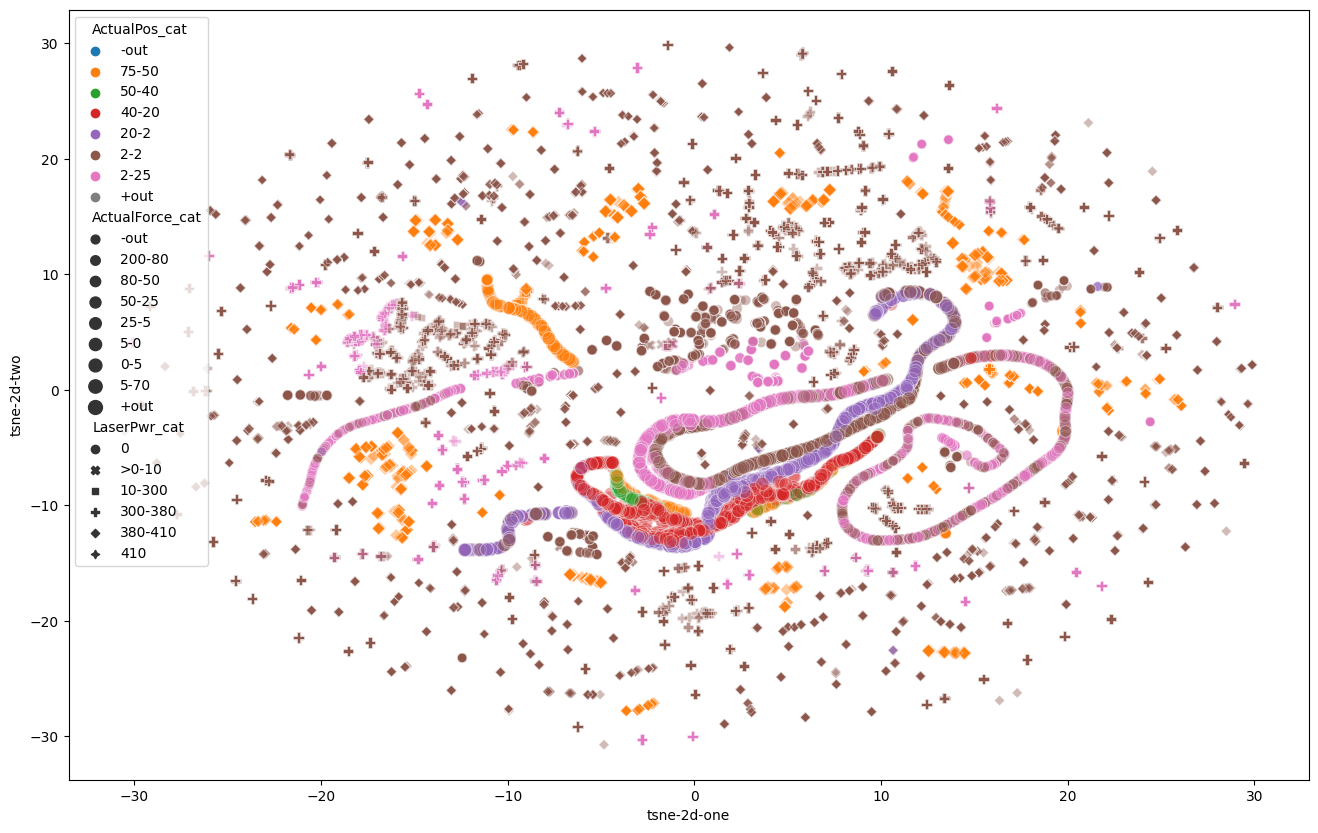

In [195]:
plt.figure(figsize=(16, 10))
sns.scatterplot(
    data=tsne_result_df,
    hue='ActualPos_cat',
    x='tsne-2d-one', y='tsne-2d-two',
    #palette=sns.color_palette("hls", 10),
    legend="full",
    alpha=0.4,
    size="ActualForce_cat",
    sizes=(100, 40), 
    style="LaserPwr_cat"
)
